############################## Patrick L. Mthisi (Patrickmthisi@hotmail.com)##########################
# Project description and objectives:
The dataset consists of gold prices. For more information  about the data used in this project, refer to:

https://www.kaggle.com/datasets/sid321axn/gold-price-prediction-dataset.

In this end-to-end project, we develop and compare two multivariate time series models: the multi-head ConvLSTM model and the multichannel CNN-LSTM model for forecasting gold prices. The following essential concepts are explored in this project:
1. Multivariate deep learning models, specifically the multi-head ConvLSTM and multichannel CNN-LSTM models, are used to forecast gold prices. An automated search of historical data is performed using a novel hybrid approach that combines random search (for broad exploration) and Bayesian optimization (for refined search) to identify the optimal parameters.
2. Automated Explanatory Data Analysis using pandas profiling.
3. Rolling Forecast: 
    - Once each model is fitted, a rolling forecast method is applied, allowing for predictions to be made one step ahead. The model is updated iteratively using actual values.
4. Model Evaluation:
    - The predicted values are compared to the actual values from the validation set.
    - The Root Mean Squared Error (RMSE) serves as the metric for assessing the model's performance.    
5. Conclusion: The study concludes with a quick review of the performances observed in this project and a comparison to the performance of the univariate case, which was investigated in another related project that we completed.

# Load libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from math import sqrt
import glob
import os
import ast
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from ydata_profiling import ProfileReport
from keras.models import Model, Sequential
from keras.layers import Input, Dropout, ConvLSTM2D, TimeDistributed, Conv1D, MaxPool1D, Flatten, BatchNormalization, LSTM, Dense, concatenate
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from keras.utils import plot_model
import json
import random
import optuna

# Helper functions
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

def difference(data, order):
    return [data[i] - data[i - order] for i in range(order, len(data))]

def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

def to_supervised(data, n_input, n_out=1):
    data = np.array(data)
    assert data.shape[1] > 1, "Dataset must have at least two columns to select the second-to-last column."
    X = np.array([data[i:i + n_input, :] for i in range(len(data) - n_input - n_out + 1)])
    y = np.array([data[i + n_input:i + n_input + n_out, -2] for i in range(len(data) - n_input - n_out + 1)])
    return X, y

csv_files = glob.glob('*.csv')
print(csv_files)

['FINAL_USO.csv']


# Load data

In [3]:
# load data
filename = 'FINAL_USO.csv'
df = pd.read_csv(filename)
columns_to_load = ['Date'] + [column for column in df.columns if column.endswith(('_Ajclose', '_Adj Close'))]
del df
series = pd.read_csv(filename, usecols=columns_to_load, header=0, parse_dates=['Date'], index_col=0)
print(series.head())

data_path = 'gold_multivariate_data'
os.makedirs(data_path, exist_ok=True)
split_point = len(series) - 21
dataset, validation = series[:split_point], series[split_point:]
print('\nData summary:')
print(f'Dataset has {len(dataset)} rows, Validation={len(validation)} has rows')
dataset.to_csv(f'{data_path}/dataset.csv', header=False)
validation.to_csv(f'{data_path}/validation.csv', header=False)

            SP_Ajclose   DJ_Ajclose  EG_Ajclose  GDX_Adj Close  USO_Adj Close
Date                                                                         
2011-12-15  105.441238  11868.80957   70.431755      48.973877      36.130001
2011-12-16  105.597549  11866.38965   72.364037      49.921513      36.270000
2011-12-19  104.468536  11766.25977   62.509384      48.490578      36.200001
2011-12-20  107.629784  12103.58008   64.731514      50.215282      37.560001
2011-12-21  107.838242  12107.74023   66.180725      50.186852      38.110001

Data summary:
Dataset has 1697 rows, Validation=21 has rows


# Explanatory data analysis

In [19]:
class eda(object):
    def __init__(self, series):
        self.series = series
        
    def line_plots(self):
        (self.series /series.iloc[0]).plot(title='Scaled historical financial data', figsize=(12, 7), alpha=0.5)
        plt.show()
        
    def density_plots(self):
        plt.figure(figsize=(12, 7))
        for col, label in zip(self.series_scaled.columns, self.label):
            self.series_scaled[col].plot(kind='kde', lw=.9, label=label, ax=plt.gca())
        plt.legend(title="Assets")
        plt.title("Kernel Density Estimate (KDE) of Scaled Series")
        plt.xlabel("Scaled Values")
        plt.ylabel("Density")
        plt.show()
        
    def resid_plots(self):
        # Columns to compare with 'GDX_Adj Close'
        cols = self.series_scaled.columns.difference(['GDX_Adj Close']).to_list()
        fig, axes = plt.subplots(2, 2, figsize=(12, 7))
        axes = axes.flatten()
        for i, col in enumerate(cols):
            sns.residplot(data=self.series_scaled, x=col, y='GDX_Adj Close', lowess=True, line_kws=dict(color="r"), ax=axes[i])
            axes[i].set_title(f'Residual Plot: {col} vs GDX_Adj Close')

        # Hide any unused subplots
        for j in range(len(cols), len(axes)):
            axes[j].set_visible(False)
            
        plt.tight_layout()
        plt.show()
        
    def generate_eda_report(self):
        os.makedirs('Reports', exist_ok=True)
        profile = ProfileReport(self.series, correlations={"auto": {"calculate": False}}, tsmode=True)
        profile.to_file("./Reports/profile_output.html")

In [20]:
eda_tsa = eda(series=series)

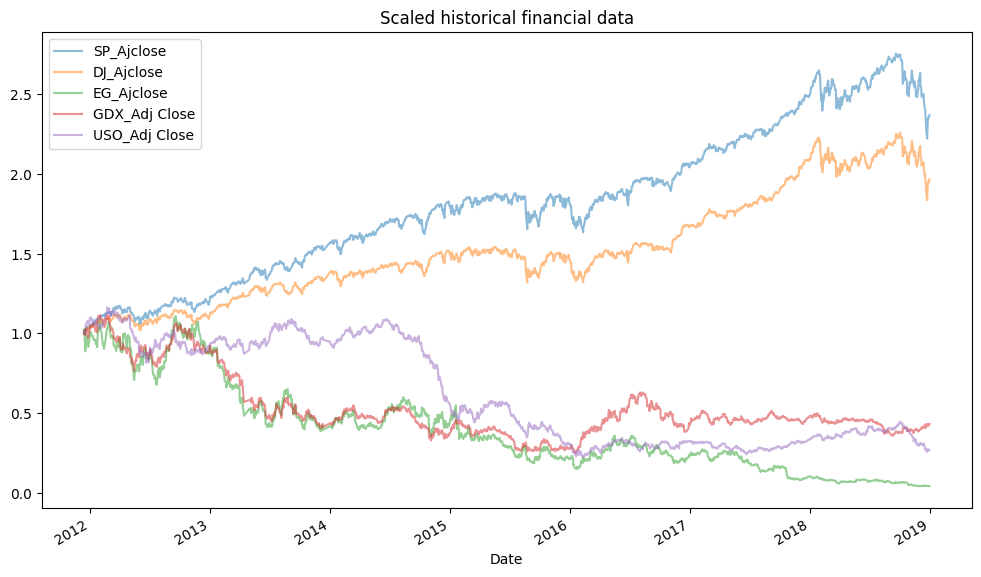

In [21]:
eda_tsa.line_plots()

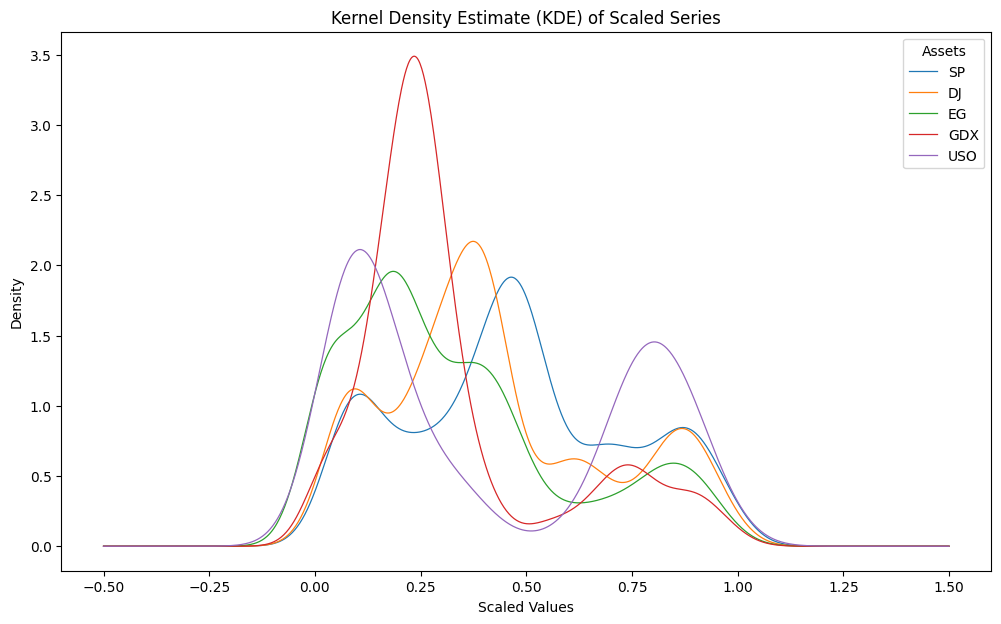

In [7]:
eda_tsa.density_plots()

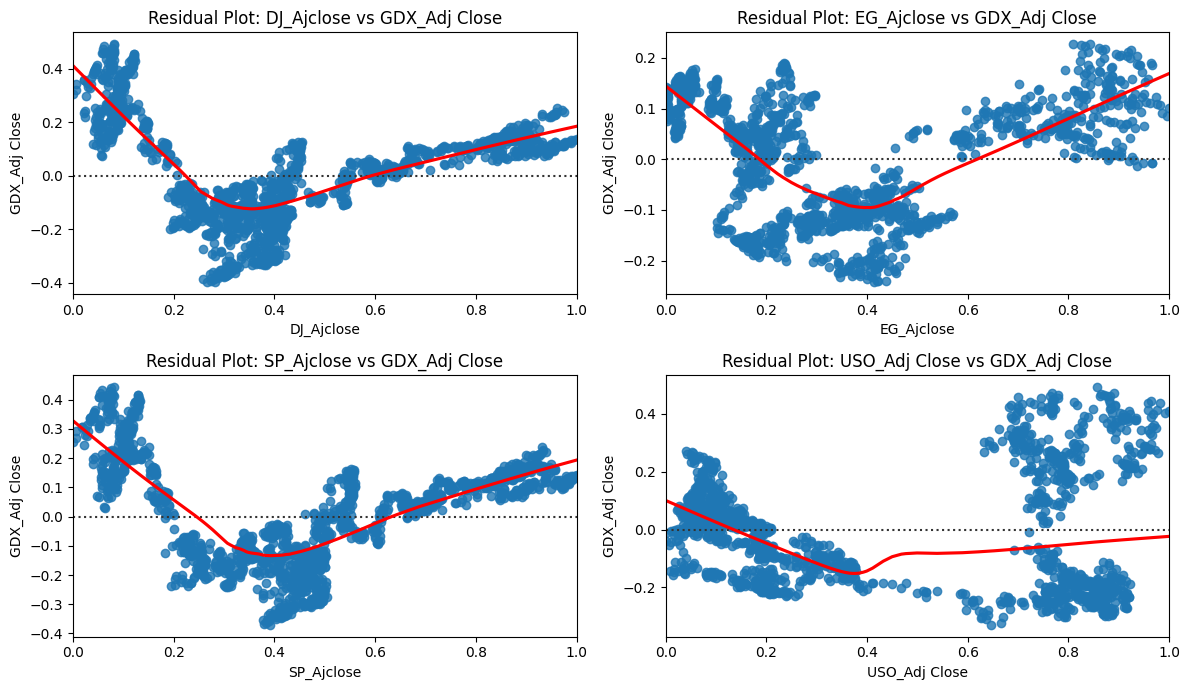

In [8]:
eda_tsa.resid_plots()

In [9]:
eda_tsa.generate_eda_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Multi-head ConvLSTM Model

In [8]:
def build_model(train, config):
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch, n_diff = config
    n_input = n_seq * n_steps
    if n_diff > 0:
        train = difference(train, n_diff)
    train_X, train_y = to_supervised(train, n_input)
    n_features, n_outputs = train_X.shape[2], train_y.shape[1]
    in_layers, out_layers = [], []
    for _ in range(n_features):
        inputs = Input(shape=(n_seq, 1, n_steps, 1))
        convlstm = ConvLSTM2D(filters=n_filters, kernel_size=(1, n_kernel), activation='relu')(inputs)
        flat = Flatten()(convlstm)
        flat = BatchNormalization()(flat)
        in_layers.append(inputs)
        out_layers.append(flat)
    merged = concatenate(out_layers)
    dense1 = Dense(n_nodes, activation='relu', kernel_regularizer=l2(0.001))(merged)
    dropout = Dropout(0.3)(dense1)
    dense2 = Dense(n_nodes, activation='relu', kernel_regularizer=l2(0.001))(dropout)
    outputs = Dense(n_outputs)(dense2)
    model = Model(inputs=in_layers, outputs=outputs)
    lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=1000, decay_rate=0.9)
    optimizer = Adam(learning_rate=lr_schedule)
    model.compile(loss='mse', optimizer=optimizer)
    plot_model(model, show_shapes=True, to_file='multiheaded_convlstm.png')
    input_data = [train_X[:, :, i].reshape((train_X.shape[0], n_seq, 1, n_steps, 1)) for i in range(n_features)]
    es = EarlyStopping(monitor='loss', mode='min', patience=20, restore_best_weights=True)
    rlp = ReduceLROnPlateau(monitor='loss', mode='min', patience=20)
    model.fit(input_data, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0, callbacks=[es, rlp])
    return model

def forecast(model, history, config):
    n_seq, n_steps, _, _, _, _, _, n_diff = config
    n_input = n_seq * n_steps
    correction = 0.0
    if n_diff > 0:
        correction = np.array(history)[-n_diff, -2]
        history = difference(history, n_diff)
    history = np.array(history)
    input_x = history[-n_input:, :]
    input_x = [input_x[:, i].reshape((1, n_seq, 1, n_steps, 1)) for i in range(input_x.shape[1])]
    yhat = model.predict(input_x, verbose=0)
    return correction + yhat[0]

def evaluate_model(data, n_test, cfg):
    train, test = train_test_split(data, n_test)
    model = build_model(train, cfg)
    history = [x for x in train]
    predictions = []
    for i in range(len(test)):
        yhat = forecast(model, history, cfg)
        predictions.append(yhat)
        history.append(test[i, :])
    error = measure_rmse(test[:, -2], np.array(predictions))
    return error

def random_sampling(data, n_test, config_space, n_samples):
    results = []
    for _ in range(n_samples):
        cfg = [random.choice(config_space[key]) for key in config_space]
        error = evaluate_model(data, n_test, cfg)
        results.append((cfg, error))
    results.sort(key=lambda x: x[1])
    return results[:5] 

def objective(trial, data, n_test):
    n_seq = trial.suggest_int("n_seq", 2, 5)
    n_steps = trial.suggest_int("n_steps", 12, 48)
    n_filters = trial.suggest_categorical("n_filters", [32, 64, 128, 256])
    n_kernel = trial.suggest_int("n_kernel", 3, 5)
    n_nodes = trial.suggest_int("n_nodes", 50, 200)
    n_epochs = trial.suggest_int("n_epochs", 50, 100)
    n_batch = trial.suggest_categorical("n_batch", [32, 64])
    n_diff = trial.suggest_int("n_diff", 0, 5)
    cfg = [n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch, n_diff]
    error = evaluate_model(data, n_test, cfg)
    return error

def bayesian_optimization(data, n_test, top_configs):
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, data, n_test), n_trials=20)
    return study.best_params, study.best_value

def hybrid_tuning(data, n_test, config_space, random_samples=20):
    print("Starting Random Sampling Phase...")
    top_random_results = random_sampling(data, n_test, config_space, random_samples)
    print("Top configurations from random sampling:")
    for cfg, error in top_random_results:
        print(f"Config: {cfg}, Error: {error:.3f}")

    print("\nStarting Bayesian Optimization Phase...")
    best_params, best_value = bayesian_optimization(data, n_test, top_random_results)
    print(f"Best configuration: {best_params}, Error: {best_value:.3f}")
    return best_params, best_value

if __name__ == '__main__':
    series = pd.read_csv(f'{data_path}/dataset.csv', header=None, parse_dates=True, index_col=0)
    data = series.values.astype('float32')
    n_test = 252

    config_space = {
        "n_seq": [3],
        "n_steps": [12, 24, 48],
        "n_filters": [32, 64, 128, 256],
        "n_kernel": [3, 5],
        "n_nodes": [100, 200],
        "n_epochs": [70],
        "n_batch": [32, 64],
        "n_diff": [0, 1, 5]
    }

    best_config, best_error = hybrid_tuning(data, n_test, config_space)
    best_config_list = list(best_config.values())
    with open(f'{data_path}/best_convlstm_cfg.json', 'w') as file:
        json.dump(best_config_list, file)

Starting Random Sampling Phase...


[I 2024-12-28 13:04:02,391] A new study created in memory with name: no-name-85ca5091-e8b6-4c48-9843-c16ae8c94a9a


Top configurations from random sampling:
Config: [3, 48, 256, 3, 100, 70, 32, 1], Error: 0.394
Config: [3, 48, 32, 5, 100, 70, 32, 1], Error: 0.419
Config: [3, 12, 256, 3, 200, 70, 32, 1], Error: 0.424
Config: [3, 12, 128, 5, 100, 70, 32, 1], Error: 0.435
Config: [3, 12, 128, 3, 200, 70, 32, 1], Error: 0.465

Starting Bayesian Optimization Phase...


[I 2024-12-28 13:05:37,341] Trial 0 finished with value: 0.5740695162589922 and parameters: {'n_seq': 2, 'n_steps': 16, 'n_filters': 64, 'n_kernel': 3, 'n_nodes': 61, 'n_epochs': 77, 'n_batch': 32, 'n_diff': 3}. Best is trial 0 with value: 0.5740695162589922.
[I 2024-12-28 13:11:07,988] Trial 1 finished with value: 0.5253809818106083 and parameters: {'n_seq': 4, 'n_steps': 47, 'n_filters': 64, 'n_kernel': 4, 'n_nodes': 139, 'n_epochs': 92, 'n_batch': 32, 'n_diff': 2}. Best is trial 1 with value: 0.5253809818106083.
[I 2024-12-28 13:12:20,817] Trial 2 finished with value: 0.6003342512043586 and parameters: {'n_seq': 4, 'n_steps': 13, 'n_filters': 32, 'n_kernel': 4, 'n_nodes': 160, 'n_epochs': 85, 'n_batch': 64, 'n_diff': 5}. Best is trial 1 with value: 0.5253809818106083.
[I 2024-12-28 13:19:59,776] Trial 3 finished with value: 0.39262247546749746 and parameters: {'n_seq': 4, 'n_steps': 39, 'n_filters': 128, 'n_kernel': 4, 'n_nodes': 179, 'n_epochs': 58, 'n_batch': 64, 'n_diff': 1}. Bes

Best configuration: {'n_seq': 5, 'n_steps': 35, 'n_filters': 128, 'n_kernel': 5, 'n_nodes': 109, 'n_epochs': 51, 'n_batch': 64, 'n_diff': 1}, Error: 0.372


# Multi-channel CNN-LSTM

In [11]:
def build_model(train, config):
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch, n_diff = config 
    n_input = n_seq * n_steps
    if n_diff > 0:
        train = difference(train, n_diff)
    train_X, train_y = to_supervised(train, n_input)
    n_features, n_outputs = train_X.shape[2], train_y.shape[1]
    train_X = np.reshape(train_X, (len(train_X), n_seq, n_steps, n_features))
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu'), 
                              input_shape=(None, n_steps, n_features)))
    model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu')))
    model.add(TimeDistributed(MaxPool1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(LSTM(n_nodes, activation='relu'))
    model.add(Dense(n_nodes, activation='relu', kernel_regularizer=l1_l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(n_nodes, activation='relu', kernel_regularizer=l1_l2(0.001)))
    model.add(Dense(n_outputs))
    lr_schedule = ExponentialDecay(initial_learning_rate=0.001, decay_steps=1000, decay_rate=0.9)
    optimizer = Adam(learning_rate=lr_schedule)
    model.compile(loss='mse', optimizer=optimizer)
    plot_model(model, show_shapes=True, to_file='multichannel_cnn-lstm.png')
    es = EarlyStopping(monitor='loss', mode='min', patience=20, restore_best_weights=True)
    lr = ReduceLROnPlateau(monitor='loss', mode='min', patience=20)
    model.fit(train_X, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0, callbacks=[es, lr])
    return model 

def forecast(model, history, config):
    n_seq, n_steps, _, _, _, _, _, n_diff = config 
    n_input = n_seq * n_steps
    correction = 0.0
    if n_diff > 0:
        correction = np.array(history)[-n_diff, -2]
        history = difference(history, n_diff)
    history = np.array(history)
    input_x = history[-n_input:, :]
    input_x = input_x.reshape((1, n_seq, n_steps, 5)) 
    yhat = model.predict(input_x, verbose=0)
    return correction + yhat[0]

def evaluate_model(data, n_test, cfg):
    train, test = train_test_split(data, n_test)
    model = build_model(train, cfg)
    history = [x for x in train]
    predictions = []
    for i in range(len(test)):
        yhat = forecast(model, history, cfg)
        predictions.append(yhat)
        history.append(test[i, :])
    error = measure_rmse(test[:, -2], np.array(predictions))
    return error

def random_sampling(data, n_test, config_space, n_samples):
    results = []
    for _ in range(n_samples):
        cfg = [random.choice(config_space[key]) for key in config_space]
        error = evaluate_model(data, n_test, cfg)
        results.append((cfg, error))
    results.sort(key=lambda x: x[1])
    return results[:5] 

def objective(trial, data, n_test):
    n_seq = trial.suggest_int("n_seq", 2, 5)
    n_steps = trial.suggest_int("n_steps", 12, 48)
    n_filters = trial.suggest_categorical("n_filters", [32, 64, 128, 256])
    n_kernel = trial.suggest_int("n_kernel", 3, 5)
    n_nodes = trial.suggest_int("n_nodes", 50, 200)
    n_epochs = trial.suggest_int("n_epochs", 50, 100)
    n_batch = trial.suggest_categorical("n_batch", [16, 32])
    n_diff = trial.suggest_int("n_diff", 0, 5)
    cfg = [n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch, n_diff]
    error = evaluate_model(data, n_test, cfg)
    return error

def bayesian_optimization(data, n_test, top_configs):
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, data, n_test), n_trials=20)
    return study.best_params, study.best_value

def hybrid_tuning(data, n_test, config_space, random_samples=20):
    print("Starting Random Sampling Phase...")
    top_random_results = random_sampling(data, n_test, config_space, random_samples)
    print("Top configurations from random sampling:")
    for cfg, error in top_random_results:
        print(f"Config: {cfg}, Error: {error:.3f}")

    print("\nStarting Bayesian Optimization Phase...")
    best_params, best_value = bayesian_optimization(data, n_test, top_random_results)
    print(f"Best configuration: {best_params}, Error: {best_value:.3f}")
    return best_params, best_value

if __name__ == '__main__':
    series = pd.read_csv(f'{data_path}/dataset.csv', header=None, parse_dates=True, index_col=0)
    data = series.values.astype('float32')
    n_test = 252

    config_space = {
        "n_seq": [3],
        "n_steps": [12, 24, 48],
        "n_filters": [32, 64, 128, 256],
        "n_kernel": [3, 5],
        "n_nodes": [50, 100, 200],
        "n_epochs": [70],
        "n_batch": [32, 64],
        "n_diff": [0, 1, 5]
    }

    best_config, best_error = hybrid_tuning(data, n_test, config_space)
    best_config_list = list(best_config.values())
    with open(f'{data_path}/best_cnn_lstm_cfg.json', 'w') as file:
        json.dump(best_config_list, file)

Starting Random Sampling Phase...


[I 2024-12-28 19:53:32,189] A new study created in memory with name: no-name-d51e74e6-0357-4acd-9ddc-6755997a8897


Top configurations from random sampling:
Config: [3, 24, 256, 5, 50, 70, 64, 1], Error: 0.417
Config: [3, 48, 64, 5, 100, 70, 32, 1], Error: 0.420
Config: [3, 12, 128, 3, 200, 70, 64, 1], Error: 0.478
Config: [3, 12, 256, 5, 50, 70, 32, 5], Error: 0.917
Config: [3, 48, 64, 3, 100, 70, 64, 5], Error: 0.985

Starting Bayesian Optimization Phase...


[I 2024-12-28 19:54:32,037] Trial 0 finished with value: 0.891907922395074 and parameters: {'n_seq': 4, 'n_steps': 20, 'n_filters': 64, 'n_kernel': 3, 'n_nodes': 115, 'n_epochs': 83, 'n_batch': 16, 'n_diff': 5}. Best is trial 0 with value: 0.891907922395074.
[I 2024-12-28 19:55:36,381] Trial 1 finished with value: 0.6831174444494504 and parameters: {'n_seq': 5, 'n_steps': 27, 'n_filters': 32, 'n_kernel': 5, 'n_nodes': 113, 'n_epochs': 89, 'n_batch': 16, 'n_diff': 3}. Best is trial 1 with value: 0.6831174444494504.
[I 2024-12-28 19:56:53,958] Trial 2 finished with value: 0.6867110320298747 and parameters: {'n_seq': 2, 'n_steps': 34, 'n_filters': 64, 'n_kernel': 5, 'n_nodes': 151, 'n_epochs': 88, 'n_batch': 16, 'n_diff': 3}. Best is trial 1 with value: 0.6831174444494504.
[I 2024-12-28 19:58:09,356] Trial 3 finished with value: 0.9331848973074487 and parameters: {'n_seq': 4, 'n_steps': 28, 'n_filters': 128, 'n_kernel': 4, 'n_nodes': 196, 'n_epochs': 61, 'n_batch': 32, 'n_diff': 4}. Best 

Best configuration: {'n_seq': 3, 'n_steps': 35, 'n_filters': 64, 'n_kernel': 5, 'n_nodes': 167, 'n_epochs': 95, 'n_batch': 16, 'n_diff': 1}, Error: 0.407


# Conclusion

This project builds upon the insights gained from a previous project where we employed a univariate time series model to forecast gold prices. In this multivariate approach, we integrate additional financial features, including stock indices and currency indices. It is commonly observed that there is a negative correlation between gold prices and financial indices such as the S&P 500 Index and the Dow Jones Index. This phenomenon aligns with the concept of "flight to safety," which occurs during periods of market turbulence as investors gravitate towards safer investments, typically gold. In this end-to-end project, we explore the application of advanced machine learning techniques, specifically the multi-head ConvLSTM and the multichannel CNN-LSTM models, to forecast gold prices by integrating a variety of relevant market variables. Our findings show that the multi-head ConvLSTM model delivered superior predictive performance compared to the multichannel CNN-LSTM model, achieving an RMSE score of 0.372. In contrast, the multichannel CNN-LSTM model recorded an RMSE of 0.407. Notably, both of these models fell short of the accuracy demonstrated by the univariate CNN-LSTM model, which stood out with an impressive RMSE score of 0.308, highlighting its effectiveness in price prediction within this context. 